In [1]:
import pandas as pd
import numpy as np
import os
import pylab
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from minepy import MINE
import scipy.stats as stats
%matplotlib inline

In [2]:
def ShowHeatMap(df, p_df, file_path, text=None):
    plt.rc('font', family='Times New Roman')
    plt.rcParams["font.size"] = 10
    colormap = plt.cm.RdBu
    xlabels = ["$Mean$", "$25\%$", "$50\%$", "$75\%$"]
    ylabels = ["$MIC$", "$CS$", "$DC$", "$PC$"]
    
    f, ax = plt.subplots(figsize=(5, 5))
    cmap = sns.diverging_palette(230, 10, as_cmap=True)
    cmap1 = sns.diverging_palette(240, 10, as_cmap=True)
    ax = sns.heatmap(df.astype(float), # 绘制的数据
                     vmin=0, vmax=1, # 设置显示的最小和最大数值
                     square=True, # 正方形热力图
                     annot=p_df, # 是否显示矩阵数值
                     annot_kws={'fontsize': 10}, # 矩阵数值显示设置
                     fmt="s",
                     cmap="YlGnBu", # 颜色
#                      cmap="Blues",
#                      cmap=cmap, # 颜色
                     
                     cbar=True, # 图例颜色条是否显示
                     cbar_kws={"shrink": 0.83},
#                      cbar_kws={"size": 16},
                     yticklabels=ylabels,
                     xticklabels=xlabels,
#                      ax=ax, # 轴
#                      cmap="bone_r"
                    )
    ax.set_xlabel("$Test$ $NSE$", fontsize=12)
    ax.set_ylabel("$Input-output\ Correlations$", fontsize=12)
    
    ax.text(-0.8, 4.6, text, fontsize=12)

    plt.savefig(file_path, dpi=1000, bbox_inches="tight")

In [3]:
def HeatMap_pipeline(data, figure_path, cor_type, text=None):
    cor_list = np.zeros([4, 4])
#     p_list = np.zeros([6, 6])
#     p_list = np.empty([6, 6], dtype = 'S20', order = 'C')
    p_list = [1, 2, 3, 4]
    for i, x in enumerate(["MIC", "CS", "DC", "PC"]):
        p_list[i] = []
        for j, y in enumerate(["mean", "25%", "50%", "75%"]):
            if cor_type == "mic":
                # 计算MIC
                mine = MINE(alpha=0.6, c=15)
                mine.compute_score(data[x], data[y])
                cor_value = mine.mic()

            if cor_type == "cc":
                # 计算cc
                df = pd.DataFrame()
                df["correlation"] = data[x]
                df["statistic"] = data[y]
#                 cor_value = df.corr(method='pearson', min_periods=1).iloc[0, 1]
                cor_value, p_value = stats.pearsonr(df["correlation"], df["statistic"])
                value_str = "0." + str(int(round(cor_value, 2)*100)) if cor_value >=0 else str(int(round(cor_value, 2)*100))[0] + "0." + str(int(round(cor_value, 2)*100))[1:]
                if p_value < 0.001:
                    p_value = value_str + "***"
                elif p_value < 0.01:
                    p_value = value_str + "**"
                elif p_value < 0.05:
                    p_value = value_str + "*"
                else:
                    p_value = value_str
                    

                    
            cor_list[i, j] = cor_value
            
            p_list[i].append(p_value)
            
    cor_df = pd.DataFrame(cor_list)
    p_df = pd.DataFrame(p_list)
    p_df = p_list


    ShowHeatMap(cor_df, p_df, figure_path, text)

In [4]:
def load_data_7(data_path, mic_path,figure_path, cor_type, text):
    metric = "test_nse"
    raw_data = pd.read_csv(data_path)

    raw_data = raw_data.drop(raw_data[raw_data[metric]<0].index)
    


    group_data = raw_data[metric].groupby([raw_data["output"], raw_data["time_steps"]])
    data_1 = group_data.describe()


    mic_data = pd.read_csv(mic_path)
    mic_data.columns = ["time_steps", 'output',"MIC", "CS", "DC", "PC", "SC", "KC"]
    
    mic_data.set_index(["output", "time_steps"], inplace=True)


    data = data_1.join(mic_data, on=["output", "time_steps"])
#     data.to_csv(figure_path)
    HeatMap_pipeline(data, figure_path, cor_type, text)

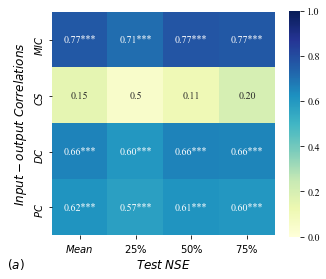

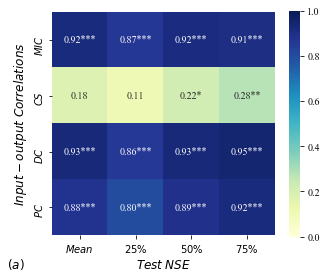

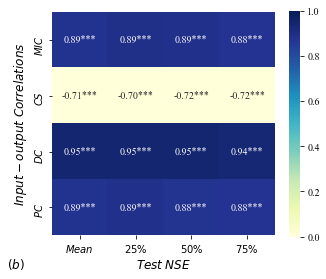

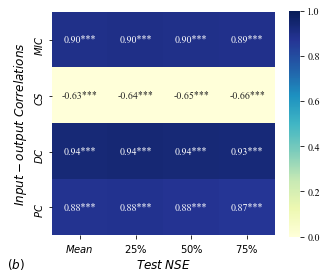

In [5]:
# 输入变量的相关性最大值
for region in ["yichang", "ziya"]:
    if region == "yichang":
        text = "$(a)$"
    else:
        text = "$(b)$"
    for test in ["a", "c"]:
        for cor_type in ["cc"]:
            data_name = test + "_train_results.csv"
            region_path = os.path.join("../test_2", region)
            data_path = os.path.join(region_path, data_name)
            ###
            mic_file_name = "relation_" + region + "_max_" + test + "_7.csv"
            
            mic_path = os.path.join("../relation_data", mic_file_name)
            
            figure_name = test + "_" + region + "_" + "heatmap" + ".jpg"
#             figure_path = region + "_mean_" + test + ".csv"
            ###
            figure_path = os.path.join("./", figure_name)
            ###
            load_data_7(data_path, mic_path, figure_path, cor_type, text)


In [6]:
# 每一类的进行合并
def load_data_7_2(data_path, mic_path,figure_path, cor_type):
    metric = "test_nse"
    raw_data = pd.read_csv(data_path)

    raw_data = raw_data.drop(raw_data[raw_data[metric]<0].index)



    group_data = raw_data[metric].groupby([raw_data["output"], raw_data["time_steps"]])
    data_1 = group_data.describe()


    mic_data = pd.read_csv(mic_path)
    mic_data.columns = ["time_steps", 'output',"MIC", "CS", "DC", "PC", "SC", "KC"]
    
    mic_data.set_index(["output", "time_steps"], inplace=True)


    data = data_1.join(mic_data, on=["output", "time_steps"])
    return data
#     data.to_csv(figure_path)

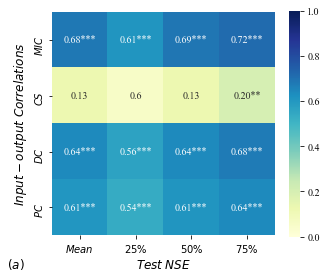

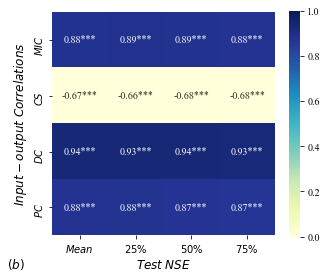

In [7]:
# 流域合在一起的相关性
for cor_type in ["cc"]:

    for region in ["yichang", "ziya"]:
        if region == "yichang":
            text = "$(a)$"
        else:
            text = "$(b)$"
        
        data_list = []
        figure_name = "a_c_" + region + "_" + cor_type + ".jpg"
        figure_path = os.path.join("./", figure_name)
        for test in ["a", "c"]:
        
            data_name = test + "_train_results.csv"
            region_path = os.path.join("../test_2", region)
            data_path = os.path.join(region_path, data_name)
            ###
            mic_file_name = "relation_" + region + "_max_" + test + "_7.csv"
            
            mic_path = os.path.join("../relation_data", mic_file_name)
            

            process_data = load_data_7_2(data_path, mic_path, figure_path, cor_type)
            data_list.append(process_data)

        data = pd.concat(data_list, axis=0, ignore_index=True)
        HeatMap_pipeline(data, figure_path, cor_type, text)

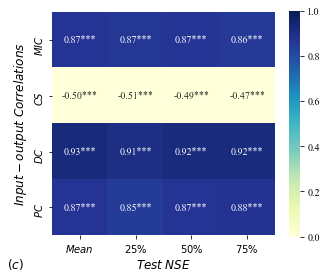

In [8]:
# 计算合在一起的相关性
for cor_type in ["cc"]:
    data_list = []
    for region in ["yichang", "ziya"]:
        figure_path = ""
        for test in ["a", "c"]:
            if test=="a" and region=="yichang":
                continue
            data_name = test + "_train_results.csv"
            region_path = os.path.join("../test_2", region)
            data_path = os.path.join(region_path, data_name)
            mic_file_name = "relation_" + region + "_max_" + test + "_7.csv"
            
            mic_path = os.path.join("../relation_data", mic_file_name)
            

            process_data = load_data_7_2(data_path, mic_path, figure_path, cor_type)
            data_list.append(process_data)
    figure_name = "a_c_" + cor_type + ".jpg"

    figure_path = os.path.join("./", figure_name)
    data = pd.concat(data_list, axis=0, ignore_index=True)

    HeatMap_pipeline(data, figure_path, cor_type, "$(c)$")
